# Solution with Neural Network only, which gives 0.547 on private leaderboard (Silver medal).


Блокнот, подводящий промежуточные итоги по подготовке данных: чистка, извлечение признаков, создание новых признаков. Предполагается, что этот блокнот будет в дальнейшем использоваться как база для исследования и сравнения различных алгоритмов машинного обучения, генерации мета-признаков и пр.

В основе заготовки - популярное решение по обработке лога от Hosseinali (и немного от Andrew Lukyanenko). К нему добавлено:

- чистка данных (удаление сессий с малым числом событий, сокращение сессий с перерывами и пр.)
- новые признаки (свойства по различным топикам, временным промежуткам, успешность в играх и пр.)
- решена проблема с невоспроизводимостью предварительной обработки данных
- включает решение 557 (https://www.kaggle.com/panikads/data-processing-consolidated-376397 - версия 2)
- включает результат рекурсивного удаления признаков (https://www.kaggle.com/ponomarevav/547-rfecv)


In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm
from collections import Counter

from catboost import CatBoostRegressor, CatBoostClassifier, cv, Pool

from sklearn.model_selection import GroupKFold

import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузка данных

In [2]:
#DATA_DIR = 'data'   # Home
#DATA_DIR = 'E:/Ponomarev/dsbowl2019/data'  # Work
DATA_DIR = '../input/data-science-bowl-2019' # Kaggle

# Разные настройки
######################################################################

RANDOM_SEED = 17


### Разное

# Сохранять обработанные наборы данных с помощью pickle
# (например, чтобы их можно было читать из других кернелов и экономить
# время на обработку)
SAVE_PROCESSED_DATASETS = True

# Сделать adversarial validation
ADVERSARIAL_VALIDATION = True

# Сохранить результаты классификации в файл (для последующего анализа ошибок)
# Увеличивает время работы ноутбука (примерно на время кросс-валидации)
SAVE_PREDICTED_TARGETS = True

# Блединг моделей с разным начальным состоянием генератора случайных чисел
# ВНИМАНИЕ! Сильно замедляет работу скрипта. Включать только для сабмита. 
# ВНИМАНИЕ! Неправильно работает в сочетании с параноидальной CV.
MULTISEED_BLEND = False
MULTISEED_BLEND_MODEL_COUNT = 5


### Предварительная обработка

# Сортировать события (устраняет ошибки в порядке событий - их мало, но они есть)
FORCE_CORRECT_EVENT_ORDER = True

# Стоит ли удалять признаки, имеющие высокую корреляцию с другими
DROP_HIGHLY_CORRELATED = False

# Стоит ли удалять признаки, которые были признаны не значимыми
# в ходе процедуры рекурсивного удаления
DROP_UNIMPORTANT = False


### Кросс-валидация

# Количество фолдов при "обычной" оценке
ORDINARY_CV = False
ORDINARY_CV_FOLD_COUNT = 5

# Кросс-валидация на разных моделях с (относительно) робастной оценкой
PARANOIDAL_CV = False
PARANOIDAL_CV_SEED_COUNT = 2
PARANOIDAL_CV_FOLD_COUNT = 3

# Кросс-валидация с одним тестом на пользователя
ONE_PER_USER_CV = False
ONE_PER_USER_CV_FOLD_COUNT = 5


### Использовать ли псевдолейблинг:
USE_PSEUDOLABELING = False
# True - используем вещественные целевые переменные, False - классы для теста при псевдолейблинге.
USE_SOFTLABELS = True

# True - использовать ли GPU для обучения (в кернеле всегда должно быть False!)
USE_GPU = False

In [3]:
%%time

train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), parse_dates=['timestamp'])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), parse_dates=['timestamp'])
                   
#specs = pd.read_csv(os.path.join(DATA_DIR, 'specs.csv')
#sample_submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

# Флаг, позволяющий отключать некоторые действия для ускорения сабмита.
# Инициализация флага основывается на том факте, что публичный тестовый набор
# содержит около 1 млн. записей, а приватный (на котором кернел работает в
# случае сабмита) - около 8 млн.
IS_SUBMITTING = test.shape[0] > 4000000

CPU times: user 2min 4s, sys: 10.9 s, total: 2min 15s
Wall time: 2min 15s


# Очистка данных

In [4]:
debug_train_size = 2 * len(train) // 3

In [5]:
# test = train[debug_train_size:].copy()
# test_labels = train_labels[debug_train_size:].copy()
# train = train[:debug_train_size].copy()
# train_labels = train_labels[:debug_train_size].copy()

## Уберем из обучающего набора те данные, которых нет в train_labels

*Замечание!* Это действие складывается из двух - удаление логов пользователей, у которых вообще нет assessment, и удаление логов пользователей, для которых нет метки в `train_labels`. Первое подмножество пользователей, очевидно, входит во второе (или совпадает с ним), поэтому удаление пользователей без assessment можно не производить, если оставляем только те, которые есть в `train_labels`. Другое дело, что обучающем наборе есть такие сессии assessment, которых почему-то нет в `train_labels` (например, b2f47fa73899b10d, 35af4f36098afcf4 и некоторые другие - `train[(~train.installation_id.isin(train_labels.installation_id.unique())) & (train.type == 'Assessment')]`), но мы можем их генерировать сами - тогда, возможно, стоит удалять логи пользователей без assessment, но отключить второй блок.

In [6]:
# При наличии следующей ячейки это и не нужно!
# 
## Выкинем из логов обучающего набора логи тех пользователей, у которых вообще нет
## assessment.
## Возможно, в дальшейшем я придумаю как их можно использовать, но пока - удаляем.
#keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
#train = pd.merge(train, keep_id, on="installation_id", how="inner")
#train.shape

In [7]:
# Выкинем из обучающего набора логи тех пользователей, которых нет 
# в train_labels
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 11)

In [8]:
# Проверим, что размер обучающего лога совпадает с имеющейся разметкой
print(f'Number of rows in train_labels: {train_labels.shape[0]}')
print(f'Number of unique game_sessions in train_labels: {train_labels.game_session.nunique()}')

Number of rows in train_labels: 17690
Number of unique game_sessions in train_labels: 17690


In [9]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1538,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1539,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
1540,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1541,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1542,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [10]:
def report_irregularities(df):
    time_delta = df.game_time - df.game_time.shift(1, fill_value=0)
    count_delta = df.event_count - df.event_count.shift(1, fill_value=0)
    print('Time delta errors:', ((time_delta  < 0) & (df.game_session == df.game_session.shift(1))).sum())
    print('Event order errors:', ((count_delta  < 0) & (df.game_session == df.game_session.shift(1))).sum())    

if FORCE_CORRECT_EVENT_ORDER:
    
    def fix_order(df):
        # Разметим сессии временем начала, чтобы они были упорядочены хронологически в рамках
        # истории пользователя
        df['session_start'] = df.groupby(['game_session'])['timestamp'].transform('min')
        # Обеспечим желаемый порядок
        df.sort_values(['installation_id', 'session_start', 'game_session', 'event_count'], inplace=True)
        df.drop(columns=['session_start'], inplace=True)    
        
    print('Forcing correct event order. Before (train):')
    report_irregularities(train)
    print('Doing sort...')
    fix_order(train)
    fix_order(test)
    print('After (train):')
    
report_irregularities(train)

Forcing correct event order. Before (train):
Time delta errors: 13
Event order errors: 122073
Doing sort...
After (train):
Time delta errors: 0
Event order errors: 0


## Решение проблемы с длинными сессиями

Потенциальных решений несколько:

- удаление аномально длинных сессий
- корректировка game_time (для сессий с перерывами) - перерыв просто "вырезается" из записи (эксперименты Татьяны показали, что это не вполне себя оправдывает. Код присутствует (но не работает) в более ранних версиях кернела.


### Просто убираем их

In [11]:
WHAT_IS_LONG = 1000 * 60 * 60 * 2 # Порог (мс), после которого сессия считается "аномально длинной"

long_sessions = train[train['game_time'] > WHAT_IS_LONG]['game_session'].unique()
# Оставляем только те записи, которые относятся не длинным сессиям или являются тестированиями
train = train[(~(train.game_session.isin(long_sessions))) | (train.type == 'Assessment')]

In [12]:
# Типы событий, соответствующие активным действиям пользователя
USER_ACTION_EVENT_CODES = [
    4010,   # Кликает для начала игры
    4020,   # Что-то куда-то тянет, перетаскивает и пр.
    4021,   # Что-то куда-то кладет
    4022,   # Что-то куда-то кладет
    4025,   # Конец перетаскивания
    4030,   # Кликает на игровой объект или начинает перетаскивать
    4031,  
    4035,   # Перетаскивает что-то куда-то не туда (!!!)
    4040,   # Что-то куда-то тащит
    4045,
    4050,
    4070,   # Misclick (!!!)
    4080,   # Наводит мышкой на интерактивный объект
    4090,   # Запрос помощи
    4095,   # Play again
    4100,   # Submit a solution
    4110,   # Submit a solution
    4220,   # Кликает на интерактивном объекте на экране победы
    4230,   # Начал тащить bath toy
    4235,   # Закончил тащить bath toy
]

# пара вспомогательных признаков по событиям
train['user_action'] = train.event_code.isin(USER_ACTION_EVENT_CODES)
train['delay'] = train.game_time - train.game_time.shift(1, fill_value=0)
test['user_action'] = test.event_code.isin(USER_ACTION_EVENT_CODES)
test['delay'] = test.game_time - test.game_time.shift(1, fill_value=0)


# Feature extraction

В этой секции осуществляется переход от логов к обычным табличным данным, в которых каждая запись содержит все признаки, на основе которых будем пытаться предсказывать результат.

Сам код взят из https://www.kaggle.com/erikbruin/data-science-bowl-2019-data-exploration, который, в свою очередь, позаимствовал его из:

- Massoud Hosseinali: https://www.kaggle.com/mhviraf/a-new-baseline-for-dsb-2019-catboost-model
- Andrew Lukyanenko



In [13]:
# Credits go to Andrew Lukyanenko

def encode_strings(train, test, train_labels):
    """
    Функция осуществляет кодирование строковых (title, world) и некоторых категорийных 
    (event_id, event_code) в числовые в диапазоне от 0 до количества уникальных значений.
    
    Возвращает модифицированные наборы и пары словарей для преобразования старого значения
        в новое и обратно.
    """
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    # ПАВ: all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = sorted(list(set(train['title'].unique()).union(set(test['title'].unique()))))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = sorted(list(set(train['event_code'].unique()).union(set(test['event_code'].unique()))))
    list_of_event_id = sorted(list(set(train['event_id'].unique()).union(set(test['event_id'].unique()))))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = sorted(list(set(train['world'].unique()).union(set(test['world'].unique()))))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = sorted(list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index))))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    
    return train, test, train_labels, win_code, list_of_user_activities, \
           list_of_event_code, activities_labels, assess_titles, list_of_event_id

# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, \
    list_of_event_code, activities_labels, assess_titles, list_of_event_id = encode_strings(train, test, train_labels)


In [14]:
# Разбиение видов заданий по тематическим частям "мира" (поле world)
world_titles = {}
for world in train.world.unique():
    world_titles[world] = list(train.title[train.world == world].unique())

In [15]:
games_titles_num = train[train['type']=='Game']['title'].unique()
games_titles = []
for i in games_titles_num:
    games_titles.append(activities_labels[i])

In [16]:
win_game_code = {'Scrub-A-Dub' : 4020, 
                 'Chow Time': 4020, 
                 'All Star Sorting' : 4020, 
                 'Air Show' : 4100, 
                 'Crystals Rule' : 4020, 
                 'Dino Drink' : 4020, 
                 'Bubble Bath' : 4020, 
                 'Dino Dive' : 4020, 
                 'Pan Balance' : 4100, 
                 'Happy Camel' : 4020, 
                 'Leaf Leader' : 4020}

In [17]:
import copy
import datetime
import bisect

# Специальный флаг для пометки значений, получающихся при делении на 0.
# Идея в том, что это значение должно находиться вне диапазона "нормальных"
# значений признака. Можно использовать np.nan и потом "чистить" пропуски.
DIV_BY_ZERO = 0

# Credits go to Massoud Hosseinali

# Эта функция осуществляет всю "магию" преобразования из лога (журнала) данных по одному
# пользователю в таблицу признаков.

def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only required
    if test_set=False
    '''
    # Constants and parameters declaration
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # News features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities} # для каждого title
    event_code_count = {eve: 0 for eve in list_of_event_code}           # для каждого event_code
    
    accumulated_game_accuracy = {game: [] for game in games_titles}

    #активных действий на раунд (за первые 3 раунда)
    action_per_round = {game: [] for game in games_titles}
    
    #переменные для фиксации промежуточных результатов по каждому тесту
    assess_interim_accuracy = {assess: [] for assess in assess_titles}
    
    # Тематические признаки (по world)
    features_by_world_template = {
        'time_spent': 0,        # время, проведенное в мире (сек)
        'actions_count': 0,     # количество действий в мире
        'session_types': {typ: 0 for typ in ['Clip', 'Activity', 'Assessment', 'Game']}, # количество сессий разных типов
        'correct_assessment_attempts': 0,    # количество правильных ответов (в тестах)
        'incorrect_assessment_attempts': 0,  # количество неправильных ответов (в тестах)
        'accumulated_interim_accuracy' : [], # точность по промежуточным действиям в тесте
        'game_accuracy' : [] ,               # точность в играх
    }
    features_by_world = {wrld: copy.deepcopy(features_by_world_template) 
                             for wrld in world_titles.keys()}
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    # Аккумулятор, в котором накапливаются записи по данному пользователю
    all_assessments = []
    accumulated_accuracy_group = []
    # Средняя точность по всем сессиям assessment
    accumulated_accuracy = 0
    
    #Точность по промежуточным действиям тестов
    accumulated_interim_accuracy = []
    
    # Общее количество правильных ответов во всех сессиях assessment
    accumulated_correct_attempts = 0 
    # Общее количество неправильных ответов во всех сессиях assessment
    accumulated_uncorrect_attempts = 0 
    # Общее количество действий, совершенных пользователем (по факту - вообще событий)
    accumulated_actions = 0
    # Количество обработанных сессий (типа assessment)
    assessment_count = 0
    # Количество законченных сессий типа assessment
    completed_assessment_count = 0
    # Количество обработанных сессий (любого типа)
    session_count = 0
    # Время первого события для текущего пользователя
    time_first_activity = float(user_sample['timestamp'].values[0])
    # Список, в который помещаются продолжительности сессий, чтобы посчитать среднюю
    durations = []
    # Точность, показанная при предыдущем выполнении теста (assessment)
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}    
    # Счетчики различных характеристик событий в истории пользователя:
    # кодов событий, идентификаторов, собственно заданий
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    # title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code} # ПАВ: чересчур!
    
    # Время окончания последней сессии (используется для определения длительных перерывов между сессиями
    # и длительных "кусков" непрерывной игры)
    last_session_finished = user_sample['timestamp'].iloc[0]
    # Начало последнего "непрерывного блока" игры (без отдыха хотя бы в 1 час)
    continuous_block_start = last_session_finished

    # Список показателей с временными метками (для определения значений
    # признаков за определенный интервал)
    # Самое простое решение - это так выбрать содержимое этих признаков, чтобы они точно соответствовали
    # каким-то переменным-аккумуляторам, используемым в этой функции
    # TODO: Это можно обобщить еще "хитрее", просто перечислив набор выражений, из которого
    #    должны формироваться такие временные срезы, а потом запускать что-то вроде eval() для каждого из
    #    этих выражений!
    timed_data_template = {
        '4070': event_code_count[4070],                                 # Количество событий 4070
        'correct_assessment_attempts': accumulated_correct_attempts,    # Количество правильных ответов на задания теста
        'incorrect_assessment_attempts': accumulated_uncorrect_attempts,# Количество неправильных ответов на задания теста
        'accumulated_assessment_accuracy': accumulated_accuracy,        # Аккумулированное значение точности (для вычисления средней)
        'assessment_count': assessment_count,                           # Количество сессий типа Assessment
        'actions': accumulated_actions,                                 # Количество действий
        'accumulated_session_duration': np.sum(durations),              # Общая продолжительность сессий
        'session_count': session_count,                                 # Количество сессий
    }
    # Принцип хранения данных с временными метками следующий:
    #   в timed_data_values хранятся агрегированные значения показателей с начала истории пользователя
    #       до окончания некоторой сессии
    #   в timed_data_time хранятся временные метки (соответствующие моментам окончания сессий)
    # Длины списков совпадают. `timed_data_time` используется для поиска нужного среза. 
    timed_data_time = [user_sample.timestamp.iloc[0] - datetime.timedelta(days=300)]
    timed_data_values = [copy.deepcopy(timed_data_template)]    
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title] # from Andrew Lukyanenko
        session_start = session['timestamp'].iloc[0]
        session_world = session['world'].iloc[0]
        
        # отбрасываем сессии, где меньше 6 событий
        # TODO: перенести в предварительную обработку?

        # if ((session_type == 'Clip') or (len(session)>5) or ((test_set) & (session_type == 'Assessment'))):
        if (session_type != 'Clip') and (len(session)<6) and (not test_set or (session_type != 'Assessment')):
            continue

        # Время начала последнего "непрерывного" блока действий, предшествующего 
        # началу данной сессии (может быть связано с утомленностью пользователя)
        # Под "непрерывным блоком" понимаем отдых меньше часа
        if (session_start - last_session_finished).seconds > 60*60:
            continuous_block_start = session_start

        # get current session time in seconds
        # Странно, что проведенное время считается только не в Assessment...
        # может, это поправить???
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent
            features_by_world[session_world]['time_spent'] += time_spent

            if session_type == 'Game':
                all_game_attempts = session.query(f'event_code == {win_game_code[session_title_text]}')
                game_true_attempts = all_game_attempts['event_data'].str.contains('true').sum()
                game_false_attempts = all_game_attempts['event_data'].str.contains('false').sum()
                if (game_true_attempts+game_false_attempts) > 0:
                    game_accuracy = game_true_attempts/(game_true_attempts+game_false_attempts) 
                    accumulated_game_accuracy[session_title_text].append(game_accuracy)
                    features_by_world[session_world]['game_accuracy'].append(game_accuracy)
                all_2030 = session[session['event_code'] == 2030].index
                if len (all_2030) > 0:
                    if len (all_2030) > 3:
                        last_2030 = all_2030[2]
                        num_rounds = 3
                    else:
                        last_2030 = all_2030[-1]
                        num_rounds = len (all_2030)
                    act_action = len(session.loc[:last_2030][session.loc[:last_2030]['user_action'] == True])
                    action_per_round[session_title_text].append(act_action/num_rounds)
                    
        # for each assessment, and only this kind of session, the features below are processed
        # and a register is generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            
            #выбираем все правильные и неправильные действия вне финального Done
            all_interim_attempts = session.query(f'event_code != {win_code[session_title]}')
            true_interim_attempts = all_interim_attempts['event_data'].str.contains('true').sum()
            false_interim_attempts = all_interim_attempts['event_data'].str.contains('false').sum()  
            
            # copy a dict to use as feature template, it's initialized with some items: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())    # 'acc_XXX'
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            # features.update(time_spent_each_act.copy())  # убрал вслед за Aquino...
            
            all_game_action_per_round = []
            for game in games_titles:
                if len(accumulated_game_accuracy[game])>0:
                    features[f'game_{game}_accuracy_last'] = accumulated_game_accuracy[game][-1]            
                    features[f'game_{game}_accuracy_mean'] = np.mean(accumulated_game_accuracy[game])
                if len(action_per_round[game])>0:
                    features[f'game_{game}_action_per_round'] = action_per_round[game][-1]
                    all_game_action_per_round.append(action_per_round[game][-1])
            features['all_game_action_per_round'] = np.mean(all_game_action_per_round)
           
            # Признаки, характеризующие "разнообразие" опыта пользователя, 'var_XXX'
            variety_features = [('var_event_code', event_code_count),
                                ('var_event_id', event_id_count),
                                ('var_title', title_count),
                               # ('var_title_event_code', title_event_code_count) # ПАВ: чересчур!
                               ]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)            
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1] # from Andrew L.
            # timestamp of session start (for timed features)
            features['timestamp'] = session.timestamp.iloc[0]
            # тема (топик, world) задания
            features['world'] = session.world.iloc[0]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            # количество правильных и неправильных попыток в данной теме (world)
            for world in world_titles.keys():
                features[f'world_{world}_accumulated_correct'] = features_by_world[world]['correct_assessment_attempts']
                features[f'world_{world}_accumulated_incorrect'] = features_by_world[world]['incorrect_assessment_attempts']
                features[f'world_{world}_mean_game_accuracy'] = np.mean(features_by_world[world]['game_accuracy'])

            # количество правильных и неправильных попыток за разные промежутки времени
            for prev_days in [3, 7, 14]:
                dt = session_start - datetime.timedelta(days=prev_days)
                prev = timed_data_values[bisect.bisect_left(timed_data_time, dt)-1]
                cur = timed_data_values[-1]
                # считаем, что все признаки, лежащие в timed_features нужно формировать для каждого 
                # временного интервала. Потом это можно настроить.
                for feature in timed_data_template.keys():
                    features['%ddays_%s' % (prev_days, feature)] = cur[feature] - prev[feature]
                
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # запомним также статистику правильности ответов в данной теме
            features_by_world[session_world]['correct_assessment_attempts'] += true_attempts
            features_by_world[session_world]['incorrect_assessment_attempts'] += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = DIV_BY_ZERO
                features['duration_std'] = DIV_BY_ZERO
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accuracy is the all time wins divided by the all time attempts
            features['mean_accuracy2'] = accumulated_accuracy/assessment_count if assessment_count > 0 else DIV_BY_ZERO
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy            
            ## Целевые признаки (не забывать удалять их все перед обучением!)
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features['accuracy'] = accuracy
            features['num_correct'] = true_attempts
            features['num_incorrect'] = false_attempts
            ##

            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            
            features['current_assess_interim_accuracy'] = np.mean(assess_interim_accuracy[session_title_text])
            for world in world_titles.keys():
                features[f'world_{world}_accumulated_interim_accuracy'] = np.mean(features_by_world[world]['accumulated_interim_accuracy'])            
            features['accumulated_interim_accuracy'] = np.mean(accumulated_interim_accuracy)
            if (true_interim_attempts+false_interim_attempts) >0:
                interim_accuracy = true_interim_attempts/(true_interim_attempts+false_interim_attempts) 
                accumulated_interim_accuracy.append(interim_accuracy)
                features_by_world[session_world]['accumulated_interim_accuracy'].append(interim_accuracy)
                assess_interim_accuracy[session_title_text].append(interim_accuracy)
            
            # mean of the all accuracy groups of this player
            if len(accumulated_accuracy_group) > 0:
                features['accumulated_accuracy_group'] = np.mean(accumulated_accuracy_group)
            accumulated_accuracy_group.append(features['accuracy_group'])

            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            # непрерывное время взаимодействия с приложением к моменту начала сессии (секунды)
            features['continuous_block'] = (session_start - continuous_block_start).seconds
            # количество действий к данному моменту в каждой из тем (world)
            for world in world_titles.keys():
                features['world_%d_action_count' % (world,)] = features_by_world[world]['actions_count']
            # количество сессий разных типов в каждой из тем (world)
            for world in world_titles.keys():
                for typ in ['Clip', 'Activity', 'Assessment', 'Game']:
                    features['world_%d_%s_count' % (world, typ)] = features_by_world[world]['session_types'][typ]

            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110

            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                completed_assessment_count += 1

            assessment_count += 1

        # С помощью этой функции и ее вызовов (которые следуют непосредственно за ней)
        # подсчитываются количества разных видов событий в сессии и истории пользователя
        def update_counters(counter: dict, col: str):
            num_of_session_count = Counter(session[col])
            for k in num_of_session_count.keys():
                x = k
                if col == 'title':
                    x = activities_labels[k]
                counter[x] += num_of_session_count[k]
            return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        # title_event_code_count = update_counters(title_event_code_count, 'title_event_code') # ПАВ: чересчур!
            
        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        user_activities_count[session_type] += 1
        features_by_world[session_world]['actions_count'] += len(session)
        features_by_world[session_world]['session_types'][session_type] += 1

        # отметим время завершения сессии
        last_session_finished = session.timestamp.iloc[-1]

        # общее количество обработанных сессий
        session_count += 1
        
        # занесем агрегированные данные в наш аккумулированный временной ряд
        timed_data_time.append(last_session_finished)
        timed_data_values.append({
            '4070': event_code_count[4070],                                 # Количество событий 4070
            'correct_assessment_attempts': accumulated_correct_attempts,    # Количество правильных ответов на задания теста
            'incorrect_assessment_attempts': accumulated_uncorrect_attempts,# Количество неправильных ответов на задания теста
            'accumulated_assessment_accuracy': accumulated_accuracy,        # Аккумулированное значение точности (для вычисления средней)
            'assessment_count': assessment_count,                           # Количество (завершенных) сессий типа Assessment
            'actions': accumulated_actions,                                 # Количество действий
            'accumulated_session_duration': np.sum(durations),              # Общая продолжительность сессий
            'session_count': session_count,                                 # Количество сессий
        })        
        
    # if test_set=True, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in train_set, all assessments are kept
    return all_assessments

In [18]:
# Credits go to Massoud Hosseinali

# The get_data function is applied to each installation_id and added to the compile_data list
compiled_data = []
# tqdm is the library that draws the status bar below
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=train.installation_id.nunique(), desc='Installation_id', position=0):
    # user_sample is a DataFrame that contains only one installation_id
    compiled_data += get_data(user_sample)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
# Credits go to Massoud Hosseinali

# Compiled_data is converted into a DataFrame and deleted to save memory
train_wide = pd.DataFrame(compiled_data)
del compiled_data
train_wide.shape

(17687, 593)

## Создание дополнительных признаков

In [20]:
def make_features(train_wide):
    # Признак "поздно"
    train_wide['late'] = ((train_wide.timestamp.dt.hour >= 21) | (train_wide.timestamp.dt.hour < 4)).astype('int')
    
    # "Продолжительность игры в определенном разделе мира"
    for world in world_titles.keys():
        activities_titles = map(lambda x: activities_labels[x], world_titles[world])
        train_wide['world_%d_total_time' % (world,)] = train_wide[activities_titles].sum(axis=1)    
        
    # Интегральная точность по каждому из топиков
    for world in world_titles.keys():
        # Это способ расчета по общему количеству ответов
        train_wide[f'world_{world}_accuracy1'] = train_wide[f'world_{world}_accumulated_correct'] / (train_wide[f'world_{world}_accumulated_correct'] + train_wide[f'world_{world}_accumulated_incorrect'] + 0.1)
        # TODO: Это способ расчета по точности на каждом тесте (как в process())
        
    # Статистика и успеваемость по текущему топику
    # TODO: отрефакторить!!! (select?)
    for feature_suffix in ['total_time', 
                           'accumulated_correct', 
                           'accumulated_incorrect', 
                           'accuracy1',
                           'accumulated_interim_accuracy',
                           'mean_game_accuracy'
                          ]:
        train_wide[f'current_world_{feature_suffix}'] = 0
        for world in world_titles.keys():
            train_wide.loc[(train_wide.world == world), [f'current_world_{feature_suffix}']] = train_wide[f'world_{world}_{feature_suffix}'][train_wide.world == world]
    for typ in ['Clip', 'Activity', 'Assessment', 'Game']:
        train_wide['current_world_%s_count' % (typ,)] = 0
        for world in world_titles.keys():
            train_wide.loc[(train_wide.world == world), ['current_world_%s_count' % (typ,)]] = train_wide['world_%d_%s_count' % (world, typ)][train_wide.world == world]

    # Нормализация временных признаков
    for prev_days in [3, 7, 14]:
        train_wide[f'{prev_days}days_assessment_accuracy_mean'] = train_wide[f'{prev_days}days_accumulated_assessment_accuracy'] / (train_wide[f'{prev_days}days_assessment_count'] + 0.01)
        train_wide[f'{prev_days}days_4070_ratio'] = train_wide[f'{prev_days}days_4070'] / (train_wide[f'{prev_days}days_actions'] + 0.01)
            
    # Для обеспечения воспроизводимости результатов, признаки необходимо упорядочить
    # (заодно перейдем к исключительно строковым названиям)

    # Сначала перейдем к колонкам-строкам (иначе можем "споткнуться" о невозможность сравнения)
    train_wide.rename(columns=str, inplace=True)
    # Теперь просто отсортируем колонки
    train_wide = train_wide[sorted(train_wide.columns.to_list())]    
    
    return train_wide

In [21]:
# Добавляем все дополнительные признаки
train_wide = make_features(train_wide)

In [22]:
train_wide.head()

,0,0086365d,00c73085,01ca3a3c,022b4259,02a42007,0330ab6a,0413e89d,04df9b66,05ad839b,...,world_3_Assessment_count,world_3_Clip_count,world_3_Game_count,world_3_accumulated_correct,world_3_accumulated_incorrect,world_3_accumulated_interim_accuracy,world_3_accuracy1,world_3_action_count,world_3_mean_game_accuracy,world_3_total_time
0,0,0,0,0,0,23,0,0,0,0,...,0,7,3,0,0,NaN,0.000000,410,0.301587,410
1,0,0,0,0,15,23,0,0,0,0,...,1,10,5,1,0,0.833333,0.909091,906,0.364286,906
2,1,0,0,0,15,23,0,0,0,0,...,2,10,5,1,11,0.484848,0.082645,993,0.364286,993
3,2,0,0,0,15,70,0,14,0,0,...,4,16,6,2,11,0.656566,0.152672,1428,0.470238,1428
4,2,0,0,0,24,70,0,14,0,0,...,5,20,8,3,12,0.659091,0.198675,1854,0.512401,1854


## Удаление откровенно "мусорных" признаков

In [23]:
#убираем все признаки, которые имеют постоянные значения более чем для 99% наблюдений
del_cols = []
for col in train_wide.columns.values:
    if len(train_wide[col].value_counts())>0:
        counts = train_wide[col].value_counts().iloc[0]
        if (counts / train_wide.shape[0]) >= 0.99:
            del_cols.append(col)
    else:
        del_cols.append(col)
print(str(len(del_cols)) + " features removed!")
train_wide.drop(del_cols, inplace = True, axis = "columns")
print(del_cols)

30 features removed!
['01ca3a3c', '0ce40006', '119b5b02', '13f56524', '16667cc5', '1b54d27f', '26a5a3dd', '29a42aea', '2ec694de', '30df3273', '3a4be871', '5f5b2617', '6077cc36', '611485c5', '6f445b57', '7fd1ac25', '9554a50b', 'ab4ec3a4', 'bfc77bd6', 'dcb1663e', 'e4d32835', 'ecc6157f', 'world_2_Activity_count', 'world_2_Assessment_count', 'world_2_Game_count', 'world_2_accumulated_correct', 'world_2_accumulated_incorrect', 'world_2_accumulated_interim_accuracy', 'world_2_accuracy1', 'world_2_mean_game_accuracy']


In [24]:
#определяем и убираем все признаки, которые имеют одинаковые значения более чем для 99% наблюдений
same_features = {}
counter = 0 
for i_col in tqdm(train_wide.columns.values, total = len(train_wide.columns.values)):
    for j_col in train_wide.columns.values:
        if i_col == j_col:
            continue
        if i_col in same_features:
            if j_col in same_features[i_col]:
                continue
        if j_col in same_features:
            if i_col in same_features[j_col]:
                continue
        same = False
        for col in same_features:
            if i_col in same_features[col] and j_col in same_features[col]:
                same = True
        if same:
            continue
        same_amount = np.sum((train_wide[i_col] == train_wide[j_col]).astype(int)) / train_wide.shape[0]
        if same_amount >= 0.99:
            if not i_col in same_features:
                same_features[i_col] = []
            same_features[i_col].append(j_col)
same_features

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


{'1340b8d7': ['4220'],
 '155f62a4': ['5b49460a'],
 '1996c610': ['4031'],
 '1c178d24': ['250513af'],
 '1cf54632': ['99abe2bb', '99ea62f3'],
 '2040': ['dcaede90'],
 '2050': ['37c53127'],
 '222660ff': ['38074c54'],
 '27253bdc': ['Clip'],
 '3afde5dd': ['b012cd7f'],
 '3bb91dda': ['c54cf6c5'],
 '3bfd1a65': ['db02c830'],
 '3dfd4aa4': ['83c6c409'],
 '4050': ['a1192f43'],
 '4230': ['4235', '85de926c', 'ad148f58'],
 '45d01abe': ['7525289a'],
 '48349b14': ['cc5087a3'],
 '4b5efe37': ['b7dc8128'],
 '5000': ['a6d66e51'],
 '5010': ['71e712d8'],
 '51311d7a': ['c6971acf'],
 '58a0de5c': ['9b4001e4'],
 '65a38bf7': ['7ad3efc6'],
 '736f9581': ['9b23e8ee'],
 '89aace00': ['e5734469'],
 '90d848e0': ['world_1_Assessment_count'],
 'Welcome to Lost Lagoon!': ['world_2_Clip_count',
  'world_2_action_count',
  'world_2_total_time'],
 'b120f2ac': ['c277e121'],
 'b2e5b0f1': ['b74258a0', 'ecaab346'],
 'world_0_action_count': ['world_0_total_time'],
 'world_1_action_count': ['world_1_total_time'],
 'world_3_action_cou

In [25]:
drop2 = []
for value in same_features.values():
    drop2+=value
drop2

['4220',
 '5b49460a',
 '4031',
 '250513af',
 '99abe2bb',
 '99ea62f3',
 'dcaede90',
 '37c53127',
 '38074c54',
 'Clip',
 'b012cd7f',
 'c54cf6c5',
 'db02c830',
 '83c6c409',
 'a1192f43',
 '4235',
 '85de926c',
 'ad148f58',
 '7525289a',
 'cc5087a3',
 'b7dc8128',
 'a6d66e51',
 '71e712d8',
 'c6971acf',
 '9b4001e4',
 '7ad3efc6',
 '9b23e8ee',
 'e5734469',
 'world_1_Assessment_count',
 'world_2_Clip_count',
 'world_2_action_count',
 'world_2_total_time',
 'c277e121',
 'b74258a0',
 'ecaab346',
 'world_0_total_time',
 'world_1_total_time',
 'world_3_total_time']

In [26]:
train_wide.drop(drop2, inplace = True, axis = "columns")

## Удаление избыточных признаков (спорно)

Оставил ради простоты эксперимента в будущем. Вообще, был свидетелем небольшого улучшения CV при уменьшении LB.

In [27]:
# удалим признаки с высокой корреляцией
# TODO: при попарном удалении признаков хорошо бы удалять наименее "осмысленные"... 
#  по принципу формирования, например...

if DROP_HIGHLY_CORRELATED:
    
    drop_features = set()
    for i, candidate_feature in enumerate(train_wide.columns):
        # print('Considering', candidate_feature)
        for existing_feature in train_wide.columns[:i]:
            if existing_feature not in drop_features:
                try:
                    cr = train_wide[candidate_feature].corr(train_wide[existing_feature])
                    if cr > 0.99:
                        drop_features.add(candidate_feature)
                        print('Dropping feature', candidate_feature, existing_feature, train_wide[candidate_feature].corr(train_wide[existing_feature]))
                        break
                except:
                    print('Error', existing_feature, candidate_feature)    

    print('Dropping due to high correlation:', drop_features)
                    
    train_wide.drop(columns=list(drop_features), inplace=True)
    
train_wide.shape

(17687, 550)

In [28]:
# Удаление признаков, "рекомендованных" процедурой рекурсивной чистки
# по важности
if DROP_UNIMPORTANT:
    unimportant_features = [
         '67aa2ada', '6f8106d9', '15ba1109', 'd06f75b5', '0d18d96c', 
         '731c0cbe', '3b2048ee', 'Treasure Map', 'd2659ab4', '8ac7cce4',
         '77c76bc5', '48349b14', '1cf54632', '4e5fc6f5', 'd9c005dd',
         '6088b756', '29f54413', '29bdd9ba', 'ecc36b7f', '3bb91dda',
         '8f094001', '7423acbc', 'e64e2cfd', '895865f3', '9b01374f',
         'e720d930', '3ddc79c3', '53c6e11a', 'eb2c19cd', '06372577',
         '756e5507', '46b50ba8', '0413e89d', '47f43a44', '5be391b5',
         '51311d7a', '1beb320a', 'cb1178ad', '3bb91ced', 'e04fb33d',
         '65abac75', '92687c59', 'd88ca108', '6aeafed4', '8d748b58',
         '87d743c1', '7cf1bc53', '9e6b7fb5', 'world_1_accumulated_correct', '16dffff1',
         # 50
         'fd20ea40', '28ed704e', '2',  'c189aaf2', '3323d7e9',
         '4b5efe37', 'd38c2fd7', '90ea0bac',  'abc5811c', '28520915',
         'daac11b0', 'c7f7f0e1', '6f4adc4b',  '7d5c30a2', 'f56e0afc',
         '08ff79ad', '9c5ef70c', '2070',  'world_3_accumulated_correct', '88d4a5be',
         '736f9581', 'b5053438', 'a5be6304', '3bfd1a65', '0086365d',
         '2a512369', 'world_0_Assessment_count', '1', '2035', '3dfd4aa4',
         '2050', 'ea321fb1', 'cf7638f3', '63f13dd7', '1f19558b',
         '6c930e6e', 'e37a2b78', 'a29c5338', '55115cbd', '5000',
         '155f62a4', '5859dfb6', 'world_0_Activity_count', '4095', '14de4c5d',
         '2b9272f4', 'a592d54e', '58a0de5c', '9ce586dd', '7f0836bf',
        
         #############################   100    ########################
        
         'd51b1749', 'c2baf0bd', '9d29771f', '1575e76c', 'b1d5101d',
         '7d093bf9', '85d1b0de', '532a2afb', '8d84fa81', '33505eae',
         'Heavy, Heavier, Heaviest', '5a848010', '4230', 'ec138c1c', 'f32856e4',
         '84b0e0c8', '86c924c4', '4a09ace1', 'e7e44842', '3d0b9317',
         'd3268efa', '7ab78247', '5010', '0d1da71f', 'Balancing Act',
         'world_3_Assessment_count', '6cf7d25c', '857f21c0', '160654fd', 'e3ff61fb',
        
         # ver 7
         'world_0_Game_count', 'ad2fc29c', '08fd73f3', 'e080a381', 'dcb55a27',
         'e7561dd2', '2040', '4110', 'ea296733', 'b80e5e84',
         '2060', '795e4a37', '3days_correct_assessment_attempts', '828e68f9', 'ca11f653',
         '7961e599', 'bdf49a58', 'd3640339', '86ba578b', '19967db1',
         # 150
         'ac92046e', '14days_correct_assessment_attempts', 'world_3_Game_count', '77261ab5', 'a0faea5d',
         'bc8f2793', '4d6737eb', 'e57dd7af', '6043a2b4', '71fe8f75',
         # ver 8
         '12 Monkeys', 'Costume Box', 'a1e4395d', '93edfe2e', 'f806dc10',
         '5c3d2b2f', '832735e1', '90d848e0', 'world_0_accumulated_incorrect', '4080',
         '022b4259', '25fa8af4', '1375ccb7', '17113b36', '2b058fe3',
         '15eb4a7d', 'f71c4741', '5d042115', '4050', '804ee27f',
         'c1cac9a2', '3dcdda7f', '2c4e6db0', '28f975ea', '7ec0c298',
         '49ed92e9', '7days_assessment_count', '73757a5e', '65a38bf7', '2075',
         # ver 9
         'world_1_Activity_count', 'd122731b', 'd2e9262e', '3ccd3f02', '05ad839b',
         '28a4eb9a', '69fdac0a', '6d90d394', '2dcad279', 'df4fe8b6',
        
         #############################   200  #################################
        
         '4c2ec19f', '2a444e03', '4901243f', '46cd75b4', '2081',
         '3', 'c74f40cd', 'b7530680', '598f4598', 'fbaf3456',  
         '4045', 'a1bbe385',  '67439901',  'c0415e5c',  'e79f3763',
         'Honey Cake', '709b1251', '763fc34e', '37937459',  '6f4bd64e',
         # ver 10
         '3d8c61b0', '44cb4907', 'late', 'world_3_accumulated_incorrect', 'world_0_accumulated_correct',
         'Slop Problem', '5e109ec3', '923afab1', '2230fab4', 'Rulers',
         'a5e9da97', '77ead60d', 'a8a78786', 'f5b8c21a', '4ef8cdd3',
         'fcfdffb6', 'Bubble Bath', 'bcceccc6', '7days_correct_assessment_attempts', 'a52b92d5',
         'd88e8f25', 'e9c52111', 'accumulated_correct_attempts', '0a08139c', 'Egg Dropper (Activity)',
         '4bb2f698', 'b2e5b0f1', '31973d56', '9e4c8c7b', 'a8876db3',
        
         # 250 
        
         # ver 11, 12 - пропущены из-за ошибок
         # ver 13
         '792530f8', 'Air Show', 'Leaf Leader', 'cdd22e43', '3babcb9b',
         'f54238ee', '3days_assessment_count', '26fd2d99', '5f0eb72c', 'cfbd47c8',
         '30614231', 'f93fc684', '8d7e386c', '47efca07', '14days_assessment_count',
         '15f99afc', '2dc29e21', '3d63345e', 'beb0a7b9', 'Bug Measurer (Activity)',
         'game_Bubble Bath_accuracy_last', '2080', '90efca10', '070a5291', 'Bottle Filler (Activity)',
         '8af75982', 'Bird Measurer (Assessment)', 'bd612267', 'ab3136ba', 'Crystals Rule',        

         # ver 14
         'f7e47413',  'Dino Dive',  'world_3_Activity_count',  '262136f4',  '6c517a88',
         'Flower Waterer (Activity)',  '5c2f29ca',  'Game',   'bd701df8',   '1c178d24',
         'Magma Peak - Level 1',   '7days_incorrect_assessment_attempts',   'c7fe2a55',   'df4940d3',    '3edf6747',
         '0330ab6a',   '93b353f2',   '4d911100',   '1cc7cfca',   'f3cd5473',

         #############################   300   ###############################
        
         '56cd3b43',   'Magma Peak - Level 2',   'e5c9df6f',   'Assessment',   '8fee50e2',
         'a16a373e',   '4021',   'world_1_Game_count',   'Welcome to Lost Lagoon!',   'Ordering Spheres',

         # ver 15
         '9d4e7b25',  'Tree Top City - Level 3',   '3days_incorrect_assessment_attempts',   'Lifting Heavy Things',    '1996c610',
         'game_Leaf Leader_accuracy_last',   'Happy Camel',   '1bb5fbdb',   '7dfe6d8a',   '00c73085',
         'Chicken Balancer (Activity)',   'd02b7a8e',   'a76029ee',   '4a4c3d21',   '9ed8f6da',
         '3393b68b',   '2083',   '8b757ab8',   'game_Crystals Rule_accuracy_mean',   '56817e2b',
         '91561152',   'f28c589a',   '884228c8',   '9e34ea74',   'd2278a3b',
         '36fa3ebe',   '45d01abe',   'Chow Time',   '9ee1c98c',   'd3f1e122',

         # ver16
         'c7128948', '3days_accumulated_assessment_accuracy',  '5de79a6a',  'Pan Balance',  'Tree Top City - Level 2',
         '89aace00', '222660ff',  'Tree Top City - Level 1',  'a7640a16',  'world_1_accuracy1',
        
         # 350
        
         'game_Scrub-A-Dub_accuracy_last',  'de26c3a6',  'b88f38da',  '2025',  '9de5e594',
         "Pirate's Tale", '4010', '02a42007',  'Activity',  '5e3ea25a',
         'a2df0760', 'c952eb01', 'acc_Mushroom Sorter (Assessment)',  '7days_accumulated_assessment_accuracy', '392e14df',
         'Sandcastle Builder (Activity)', 'Scrub-A-Dub',  '2fb91ec1',  'game_All Star Sorting_accuracy_last', '37db1c2f',

         # Результат работы RFECV, "натравленного" на версию 547, показал, что наибольшее значение CV 
         # (PARANOIDAL) достигается где-то при 100-150 признаках. То есть, из 532 признаков той модели
         # удалить нужно от 380 до 430. Берем по нижней границе.
        
         # ver17
         #'Dino Drink', 'current_world_Game_count', 'acc_Cauldron Filler (Assessment)', 'Crystal Caves - Level 1',  'game_Happy Camel_accuracy_last',
         #'accumulated_uncorrect_attempts', '565a3990',  'game_Dino Drink_accuracy_last', '0db6d71d', '363d3849',
         #'76babcde', 'b120f2ac', 'Mushroom Sorter (Assessment)', 'game_Chow Time_accuracy_mean', '2010',
         #'bb3e370b', 'acf5c23f', '14days_actions', '5154fc30', '14days_accumulated_assessment_accuracy',
         #'a44b10dc', '56bcd38d', 'cb6010f8', 'e4f1efe6', 'game_Air Show_accuracy_last',
         #'461eace6', 'b2dba42b', 'game_Bubble Bath_accuracy_mean', 'd185d3ea', '1af8be29',

    ]
    print('Dropping unimportant features:', unimportant_features)
    train_wide.drop(columns=unimportant_features, inplace=True)

train_wide.shape

(17687, 550)

In [29]:
train = train_wide

Если необходимо, сохраним предобработанные данные для последующего использования.

In [30]:
if SAVE_PROCESSED_DATASETS:
    with open('train_processed.pkl', 'wb') as fo:
        pickle.dump(train, fo)

In [31]:
categorical_features = ['session_title', 'world']
# Признаки, которые не нужно использовать при обучении
exclude_features = ['installation_id', 'timestamp',
                    'accuracy_group',  'num_correct', 'num_incorrect', 'accuracy']
# Целевой признак
target_feature = 'accuracy_group'

# Обучение модели

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score

# Определение требуемой метрики 'quadratic weighted kappa'
scorer = lambda estimator, x, y : cohen_kappa_score(estimator.predict(x), y, weights='quadratic')

In [33]:
from numba import jit

@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


In [34]:
from functools import partial
import scipy as sp

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']
    
    
class MultistartOptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coefs = [[0.5, 1.5, 2.5],
                         [1.1, 1.6, 2.2],
                         [1.2, 1.7, 2.1]]
        best_val = 10.0                    # значение берется с обратным знаком
        best_coef = None
        for coef in initial_coefs:
            cur_coef = sp.optimize.minimize(loss_partial, coef, method='nelder-mead')
            cur_val = self._kappa_loss(cur_coef['x'], X, y)
            print('Val:', cur_val)
            if cur_val < best_val:         # значение берется с обратным знаком
                print('New best!')
                best_val = cur_val
                best_coef = cur_coef
        self.coef_ = best_coef

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']    

## Строим Нейронную сеть:

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

In [36]:
## это нужно для того, чтобы эмбеддинге pytorch правильно построились
train['session_title'] = train['session_title'].map({4: 0, 8: 1, 9: 2, 10: 3, 30: 4})
train['world'] = train['world'].map({0: 0, 1: 1, 3: 2})

In [37]:
## пока что заполняем  nans - '-1'. Потом, возможно, можно это сделать более умным способом.
train.fillna(-1, inplace=True)

In [38]:
## шкалируем данные

from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scal = StandardScaler()
numerical_columns = list(set(train.columns) \
                         - set(categorical_features) - set(exclude_features)) 
train[numerical_columns] = std_scal.fit_transform(train[numerical_columns].values.astype(np.float64))


In [39]:
#эмбеддинги для категориальных признаков, которые имеют более 2 уникальных значений
embedded_cols =  {col_name: len(train[col_name].unique()) for n, col_name in enumerate(categorical_features) if train[categorical_features[n]].nunique() > 2}
embedded_col_names = embedded_cols.keys() # название фичей, для которых будут созданы эмбеддинги
embedding_sizes = [(c, min(50, (c+1)//2)) for _,c in embedded_cols.items()] #размеры эмбеддингов

**Создание датасета:**

In [40]:
class DSBDataset(Dataset):
    def __init__(self, X, Y=None, embedded_col_names=None):
        self.X1 = X.loc[:,embedded_col_names].copy().values.astype(np.int64) #categorical columns
        self.X2 = X.drop(columns=embedded_col_names).copy().values.astype(np.float32) #numerical columns
        if Y is None:
            self.y = None
        else:
            self.y = Y.values.astype(float)
        
    def __len__(self):
        return len(self.X1)
    
    def __getitem__(self, idx):
        if self.y is None:
            return self.X1[idx], self.X2[idx]
        else:
            return self.X1[idx], self.X2[idx], self.y[idx]

In [41]:
## Решил пока оставить только CPU, так как в кернеле все равно нельзя использовать GPU
def get_default_device():
    if torch.cuda.is_available() & USE_GPU:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [42]:
## переносим данные на девайс

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [43]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Количество батчей"""
        return len(self.dl)

## Архитектура нейронной сети:

In [44]:


class DSBModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont,
                 input_size_list = [350, 250, 200, 100, 1],
                 dropout_list = [0.3, 0.5, 0.5, 0.5, 0.5]):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) # длина всех эмбеддингов
        self.n_emb, self.n_cont = n_emb, n_cont
        self.layer_list = [nn.Linear(self.n_emb + self.n_cont,
                                     input_size_list[0])]
        self.batchnorm_list = [nn.BatchNorm1d(self.n_cont)]
        self.dropout_list = [nn.Dropout(dropout_list[0])]
        for i in range(0, len(input_size_list[:-1])):
            self.dropout_list.append(nn.Dropout(dropout_list[i]))
            self.batchnorm_list.append(nn.BatchNorm1d(input_size_list[i]))
            self.layer_list.append(nn.Linear(input_size_list[i],
                                             input_size_list[i+1]))
        self.layer_list = nn.ModuleList(self.layer_list)
        self.batchnorm_list = nn.ModuleList(self.batchnorm_list)
        self.dropout_list = nn.ModuleList(self.dropout_list)
        

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:, i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x2 = self.batchnorm_list[0](x_cont)
        x = self.dropout_list[0](x)
        x = torch.cat([x, x2], 1)
        x = F.leaky_relu(self.layer_list[0](x), negative_slope=0.002)
        for i in range(1, len(self.layer_list)):
            x = self.batchnorm_list[i](x)
            x = self.dropout_list[i](x)
            x = F.leaky_relu(self.layer_list[i](x), negative_slope=0.002)
        
        return x

In [45]:
device = get_default_device()
device

device(type='cpu')

 ## "Early stopping" - завершение обучения модели при неуменьшении лосса на валидационной выборке.

In [46]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=True):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model_params_list, experiment_name, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model_params_list, experiment_name, epoch)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model_params_list, experiment_name, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, experiment_name, epoch):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')


#             model_full_state = {'model': model_param_list[0].state_dict()}
                                #'optim': model_param_list[1].state_dict()}

            # if model_param_list[2] is not None:
            #     model_full_state.update({'Scheduler' : model_param_list[2].state_dict()})
            # else:
            #     model_full_state.update({'Scheduler': None})

            torch.save(model.state_dict(), 'best_model.pth')
            self.val_loss_min = val_loss


In [47]:
# перепишем ClassifierWrapper:
from sklearn.model_selection import train_test_split



class ClassifierWrapperNN():
    def __init__(self, model, optimizer,
                 scheduler=None,
                 batch_size=750, valid_size=0.2,
                 embedded_col_names=None):
        super().__init__()
        
        
        if USE_GPU:
            self.model = model.cuda()
        else:
            self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.optimized_rounder = MultistartOptimizedRounder()
        self.batch_size = batch_size
        
        ## размер валидационной выборки при обучении
        self.valid_size = valid_size
        ## признаки, для которых нужны эмбеддинги
        self.embedded_col_names = embedded_col_names
        
        self.early_stopping = EarlyStopping(10)
        
    def fit(self, X, y, X_val=None, y_val=None, epochs=15):
        ## нужна еще одна валидационная выборка, иначе оценка модели не будет честной
        without_valid_set = None
        if X_val is None:
            valid_ids = (np.random.choice(X.installation_id.unique(),
                                  int(len(X)*self.valid_size)))
            valid_idx = (X[X.installation_id.isin(valid_ids)].index)
            train_idx = np.delete(X.index, valid_idx)
            X_train = X.iloc[train_idx, :].drop(columns='installation_id')
            y_train = y.iloc[train_idx]
            X_val = X.iloc[valid_idx, :].drop(columns='installation_id')
            y_val = y.iloc[valid_idx]
            without_valid_set = True
        else:
            X_train = X
            y_train = y
        ## устройство, на котором будет производиться обучение:
        self.device = get_default_device()
        ## инициализируем датасет и загрузчик данных
        train_ds = DSBDataset(X_train, y_train, self.embedded_col_names)
        valid_ds = DSBDataset(X_val, y_val, self.embedded_col_names)
        train_dl = DataLoader(train_ds, batch_size=self.batch_size, shuffle=True, num_workers=0)
        valid_dl = DataLoader(valid_ds, batch_size=self.batch_size, shuffle=False, num_workers=0)
        ## перенос данных на нужное устройство:
        self.train_dl = DeviceDataLoader(train_dl, device)
        self.valid_dl = DeviceDataLoader(valid_dl, device)
        
        # обучение
        self.train_loop(epochs=epochs)
        
        ## Чтобы подобрать пороги предскажем ответы для тренировочных данных
        if without_valid_set:
            y_pred = self.predict_regressor(X.drop(columns='installation_id'))
        else:
            y_pred = self.predict_regressor(X)
            
        y_true = y.values
        
        self.optimized_rounder.fit(y_pred.reshape(-1), y_true.reshape(-1))
        print('Found bounds:', self.optimized_rounder.coefficients())
    
    def predict_regressor(self, X):
        ## выдает вещественные ответы для X
        
        valid_ds = DSBDataset(X, Y=None, embedded_col_names=self.embedded_col_names)
        valid_dl = DataLoader(valid_ds, batch_size=self.batch_size, shuffle=False, num_workers=0)
        valid_dl = DeviceDataLoader(valid_dl, device)
        self.model.load_state_dict(torch.load('best_model.pth'))
        self.model.eval()
        preds = None
        with torch.no_grad():
            for x1, x2 in valid_dl:
                current_batch_size = x2.shape[0]
                out = self.model(x1, x2)
                if preds is None:
                    preds = out.cpu().numpy()
                else:
                    preds = np.hstack([preds.reshape(-1), out.cpu().numpy().reshape(-1)])
        return preds
    
    def predict(self, X):
        y_pred = self.predict_regressor(X)
        return self.optimized_rounder.predict(y_pred.reshape(-1),
                                              self.optimized_rounder.coefficients())
    
    def train_loop(self, epochs):
        for i in range(epochs): 
            loss = self.train_model()
            print(f"training loss: {loss:.3f}")
            val_loss = self.val_loss()
            if self.scheduler is not None:
                self.scheduler.step(val_loss)
            self.early_stopping(val_loss, self.model, None, None)
            if self.early_stopping.early_stop:
                break
        del self.train_dl, self.valid_dl
    
    def train_model(self):
        self.model.train()
        loss_list = []
        for x1, x2, y in self.train_dl:
            batch = y.shape[0]
            out = self.model(x1, x2)
            loss = torch.sqrt(F.mse_loss(out.reshape(-1), y.reshape(-1).float()))   
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_list.append((loss.item()))
        return np.mean(loss_list)
    
    def val_loss(self):
        self.model.eval()
        loss_list = []
        correct = 0
        preds = None
        y_true = None
        with torch.no_grad():
            for x1, x2, y in self.valid_dl:
                current_batch_size = y.shape[0]
                out = self.model(x1, x2)
                loss = torch.sqrt(F.mse_loss(out.reshape(-1), y.reshape(-1).float()))
                loss_list.append((loss.item()))
                if y_true is None:
                    y_true = y.cpu()
                else:
                    y_true = np.hstack([y_true.reshape(-1), y.cpu().reshape(-1).float()])
                if preds is None:
                    preds = out.cpu().numpy()
                else:
                    preds = np.hstack([preds.reshape(-1), out.cpu().numpy().reshape(-1)])
        #self.optimized_rounder.fit(preds.reshape(-1,), y_true)
        #kappa_score = qwk(self.optimized_rounder.predict(preds.reshape(-1), 
        #                                                 self.optimized_rounder.coefficients()).astype(int),
        #                  y_true)
        print(f"valid loss {np.mean(loss_list):.3f}")# and kappa {kappa_score:.3f}")
        return np.mean(loss_list)#, kappa_score


# class ClassifierWrapper1(BaseEstimator, MetaEstimatorMixin, ClassifierMixin):
    
#     def __init__(self, base_estimator):
#         super().__init__()
#         self.base_estimator = base_estimator
#         self.optimized_rounder = MultistartOptimizedRounder()

#     def make_estimator(self):
#         estimator = clone(self.base_estimator)
#         return estimator        
        
#     def fit(self, X, y):
#         self.model = self.make_estimator().fit(X, y)
#         y_pred = self.model.predict(X)
#         self.optimized_rounder.fit(y_pred.reshape(-1,), y)
#         print('Found bounds:', self.optimized_rounder.coefficients())
        
#     def predict(self, X):
#         y_pred = self.model.predict(X)
#         return self.optimized_rounder.predict(y_pred.reshape(-1, ), self.optimized_rounder.coefficients())



Optimizer

In [48]:
model = DSBModel(embedding_sizes=embedding_sizes, 
                 n_cont=len(train.drop(columns=exclude_features).columns) - len(categorical_features))
parameters = filter(lambda p: p.requires_grad, model.parameters())

lr = 0.03
wd = 1e-6
optimizer = optim.Adam(parameters, lr=lr, weight_decay=wd)

In [49]:
regressor_model = ClassifierWrapperNN(model=model, optimizer=optimizer,
                                      embedded_col_names=embedded_col_names)

In [50]:
## для воспроизводимости результатов
import random

def seed_torch(seed=13):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # если используется несколько GPU
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    

seed_torch(RANDOM_SEED)

In [51]:
%%time

regressor_model.fit(train.drop(columns=exclude_features[1:]), train['accuracy_group'], epochs=15)

training loss: 1.904
valid loss 2.190
Validation loss decreased (inf --> 2.189767).  Saving model ...
training loss: 1.545
valid loss 1.434
Validation loss decreased (2.189767 --> 1.433925).  Saving model ...
training loss: 1.505
valid loss 1.295
Validation loss decreased (1.433925 --> 1.295136).  Saving model ...
training loss: 1.326
valid loss 1.223
Validation loss decreased (1.295136 --> 1.223295).  Saving model ...
training loss: 1.330
valid loss 1.167
Validation loss decreased (1.223295 --> 1.166604).  Saving model ...
training loss: 1.211
valid loss 1.166
Validation loss decreased (1.166604 --> 1.166253).  Saving model ...
training loss: 1.218
valid loss 1.232
EarlyStopping counter: 1 out of 10
training loss: 1.221
valid loss 1.179
EarlyStopping counter: 2 out of 10
training loss: 1.216
valid loss 1.171
EarlyStopping counter: 3 out of 10
training loss: 1.312
valid loss 1.148
Validation loss decreased (1.166253 --> 1.148442).  Saving model ...
training loss: 1.173
valid loss 1.164

<ipython-input-33-7e6567382b89>:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "qwk" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-33-7e6567382b89> (13)

File "<ipython-input-33-7e6567382b89>", line 13:
def qwk(a1, a2):
    <source elided>
    """
    max_rat = 3
    ^

  @jit
<ipython-input-33-7e6567382b89>:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "qwk" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-33-7e6567382b89>", line 21:
def qwk(a1, a2):
    <source elided>
    o = 0
    for k in range(a1.shape[0]):
    ^

  @jit
/opt/conda/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "qwk" was compiled in object mode without forceobj=True, but has lifted loops.

File "<ipython-input-33-7e6567382b89>", line 

Val: -0.4700782345057597
New best!
Val: -0.4886435276137999
New best!
Val: -0.487188926924946
Found bounds: [1.2048009  1.97340801 2.30882332]
CPU times: user 44.9 s, sys: 353 ms, total: 45.2 s
Wall time: 22.5 s


In [52]:
# if MULTISEED_BLEND:
#     from sklearn.ensemble import VotingRegressor
#     template_model = CatBoostRegressor()
#     base_models = []
#     for i in range(MULTISEED_BLEND_MODEL_COUNT):
#         model = clone(template_model)

#         model.set_params(**{'random_state': RANDOM_SEED+i,
#                                         'iterations': 1000,
#                                         'verbose': 100,
#                                         'cat_features': categorical_features})
#         base_models.append((f'model_{i+1}', model))

#     rgr_model = ClassifierWrapper1(VotingRegressor(estimators=base_models))

# else:
    
#     rgr_model = ClassifierWrapper(CatBoostRegressor(), {'random_state': RANDOM_SEED,
#                                                         'iterations': 1000,
#                                                         'verbose': 100,
#                                                         'cat_features': categorical_features})

X = train.drop(columns=exclude_features)
y = train[[target_feature]]

## Кросс-валидация

In [53]:
import random
from sklearn.model_selection import KFold

class OneTestPerGroupKFold:
    """
    Генерация фолдов для кросс-валидации, в которых в тестовой части будет
    только по одной записи от каждого пользователя (installation_id).
    """
    
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        if shuffle:
            self.splitter = KFold(n_splits, shuffle=True, random_state=random_state)
        else:
            self.splitter = KFold(n_splits)
        if random_state is None:
            random_state = 0
        self.random = random.Random(random_state)
        
    def get_n_splits(self):
        return self.n_splits
    
    def split(self, X, groups):
        # Составим вспомогательный набор с отображением атрибута
        # группировки (installation_id) на порядковый индекс 
        # соответствующей записи
        tt = pd.DataFrame({'group': groups, 'idx': np.arange(groups.shape[0])})
        # Выбираем по одному представителю для каждой группы
        picks = tt.groupby(['group'], sort=False)['idx'].agg(lambda x: x.iloc[self.random.randint(0, x.shape[0]-1)])
        # Генерируем фолды по группам (пользователям)
        for train_idx, test_idx in self.splitter.split(picks):
            # "Раскроем" индексы:
            # Для обучающей выборки это будут все записи соответствующих групп
            train_idx_ = tt.idx[tt.group.isin(list(picks.iloc[train_idx].index))].to_numpy(dtype='int')
            # Для тестовой выборки это будут только выбранные записи из соответствующих групп
            test_idx_ = picks.iloc[test_idx].to_numpy(dtype='int')
            yield (train_idx_, test_idx_)


In [54]:
from sklearn.base import clone


def evaluate_featureset(X, y, cv, groups=train.installation_id, model_count=2, OneTestPerGroup=False,
                        nn_params=None):
    """
    Функция оценки набора признаков (в первую очередь).
    OneTestPerGroup = True, если хотим использовать OneTestPerGroupKFold.
    """
    scores = []
    accumulated_importances = np.zeros(len(X.columns))
    # Пробуем несколько случайных состояний
    # for seed_delta in [17-RANDOM_SEED, 28-RANDOM_SEED, 45-RANDOM_SEED]:
#     first_layer_size = np.max([nn_params['first_layer_size'],
#                                    nn_params['last_layer_size']])
#     last_layer_size = np.min([nn_params['first_layer_size'],
#                                nn_params['last_layer_size']])
    input_size_list = [350, 250, 200, 100, 1]#np.sort(np.random.randint(low=last_layer_size,
                       #                 high=first_layer_size,
                        #                size=int(nn_params['layers_amount'])))[::-1]
    input_size_list[-1] = 1
    dropout_list = [0.3, 0.5, 0.5, 0.5, 0.5]#np.random.rand(int(nn_params['layers_amount'])) * 0.5 + 0.3
    for seed_delta in range(model_count):
        print('Training model with seed +', seed_delta)
        
        ## смена сида для PARANOIDAL_CV
        seed_torch(RANDOM_SEED + seed_delta)
        if OneTestPerGroup:
            splitter = cv.split(X, groups=groups)
        else:
            splitter = cv.split(X, y, groups=groups)
        
        for train_idxs, test_idxs in splitter:
            model = DSBModel(embedding_sizes, len(X.columns) - len(categorical_features),
                             input_size_list=input_size_list,
                             dropout_list=dropout_list)
            parameters = filter(lambda p: p.requires_grad, model.parameters())

            lr = 0.02
            wd = 1e-6#nn_params['weights_decay']
            optimizer = optim.Adam(parameters, lr=lr, weight_decay=wd, amsgrad=True)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                             factor=0.2,
                                                             patience=3,
                                                             verbose=True,
                                                             eps=1e-8)
            train_X = X.iloc[train_idxs, :]
            train_y = y.iloc[train_idxs, :]
            test_X = X.iloc[test_idxs, :]
            test_y = y.iloc[test_idxs, :]

            tmp_model = ClassifierWrapperNN(model=model, 
                                            optimizer=optimizer,
                                            scheduler=scheduler,
                                            embedded_col_names=embedded_col_names)
            tmp_model.fit(train_X, train_y, test_X, test_y, 100)
            ## К сожалению, feature importances не получить(
#             accumulated_importances += tmp_model.model.feature_importances_
            tmp_preds = tmp_model.predict(test_X)
            tmp_score = qwk(tmp_preds, test_y.values.reshape(-1, ))
            print('OOF score: ', tmp_score)

            scores.append(tmp_score)
    print(input_size_list,
          dropout_list)
    return np.array(scores), input_size_list, dropout_list



## Подберем параметры с помощью bayes_opt:

In [55]:
# from bayes_opt import BayesianOptimization

# best_score_and_params_ORDINARY_mean = {'score': 0,
#                                         'layers_amount': 0,
#                                         'weights_decay': 0,
#                                         'first_layer_size': 0,
#                                         'last_layer_size': 0,
#                                         'input_size_list': 0,
#                                         'dropout_list': 0}

# best_score_and_params_ORDINARY_min = {'score': 0,
#                                         'layers_amount': 0,
#                                         'weights_decay': 0,
#                                         'first_layer_size': 0,
#                                         'last_layer_size': 0,
#                                         'input_size_list': 0,
#                                         'dropout_list': 0}

# def nn_bayesian_ORDINARY(layers_amount, weights_decay, first_layer_size, 
#                 last_layer_size):#, subsample):
    
#     nn_params = {
#                  'layers_amount': layers_amount,
#                  'weights_decay': weights_decay,
#                  'last_layer_size': last_layer_size,
#                  'first_layer_size': first_layer_size}
#     splitter = GroupKFold(ORDINARY_CV_FOLD_COUNT)
#     cv_score, input_size_list, dropout_list = evaluate_featureset(X, y, splitter, model_count=1, 
#                                                 OneTestPerGroup=False, nn_params=nn_params)
#     if cv_score.mean() > best_score_and_params_ORDINARY_mean['score']:
#         best_score_and_params_ORDINARY_mean['score'] = cv_score.mean()
#         best_score_and_params_ORDINARY_mean['layers_amount'] = nn_params['layers_amount']
#         best_score_and_params_ORDINARY_mean['weights_decay'] = nn_params['weights_decay']
#         best_score_and_params_ORDINARY_mean['last_layer_size'] = nn_params['last_layer_size']
#         best_score_and_params_ORDINARY_mean['first_layer_size'] = nn_params['first_layer_size']
#         best_score_and_params_ORDINARY_mean['input_size_list'] = input_size_list
#         best_score_and_params_ORDINARY_mean['dropout_list'] = dropout_list
#     if cv_score.min() > best_score_and_params_ORDINARY_min['score']:
#         best_score_and_params_ORDINARY_min['score'] = cv_score.min()
#         best_score_and_params_ORDINARY_min['layers_amount'] = nn_params['layers_amount']
#         best_score_and_params_ORDINARY_min['weights_decay'] = nn_params['weights_decay']
#         best_score_and_params_ORDINARY_min['last_layer_size'] = nn_params['last_layer_size']
#         best_score_and_params_ORDINARY_min['first_layer_size'] = nn_params['first_layer_size']
#         best_score_and_params_ORDINARY_min['input_size_list'] = input_size_list
#         best_score_and_params_ORDINARY_min['dropout_list'] = dropout_list
        
#     cv_score = np.sort(cv_score)[1:-1]
#     return cv_score.mean()


# nn_params_bounds = {
#     'layers_amount': (1, 10),
#     'weights_decay': (1e-6, 5e-4),
#     'first_layer_size': (300, 600),
#     'last_layer_size': (10, 150)
# }

In [56]:
# %%time
# import warnings
# nn_BO = BayesianOptimization(nn_bayesian_ORDINARY, nn_params_bounds, random_state=RANDOM_SEED)

# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     nn_BO.maximize(init_points=1000, n_iter=1000, acq='ucb', xi=0, alpha=1e-3)

In [57]:
# print(f'Оптимальные параметры ORDINARY:\n{nn_BO.max}')

In [58]:
# best_score_and_params_ORDINARY_mean, best_score_and_params_ORDINARY_min

({'score': 0.5747473730904427,
  'layers_amount': 8.291512827267493,
  'weights_decay': 3.6890671667118504e-06,
  'first_layer_size': 454.59224937264935,
  'last_layer_size': 67.4819895666651,
  'input_size_list': array([391, 380, 345, 308, 307, 210, 178,   1]),
  'dropout_list': array([0.35149693, 0.4097505 , 0.61487881, 0.72996204, 0.32063628,
         0.67128311, 0.58520868, 0.3171566 ])},
 {'score': 0.5588338575413847,
  'layers_amount': 9.778262752653031,
  'weights_decay': 0.000178995134285722,
  'first_layer_size': 518.8253842758594,
  'last_layer_size': 52.96506511880656,
  'input_size_list': array([481, 458, 442, 365, 330, 293, 292, 195,   1]),
  'dropout_list': array([0.50511163, 0.35149693, 0.4097505 , 0.61487881, 0.72996204,
         0.32063628, 0.67128311, 0.58520868, 0.3171566 ])})

In [59]:
# from bayes_opt import BayesianOptimization

# best_score_and_params_PARANOIDAL_mean = {'score': 0,
#                                         'layers_amount': 0,
#                                         'weights_decay': 0,
#                                         'first_layer_size': 0,
#                                         'last_layer_size': 0,
#                                         'input_size_list': 0,
#                                         'dropout_list': 0}

# best_score_and_params_PARANOIDAL_min = {'score': 0,
#                                         'layers_amount': 0,
#                                         'weights_decay': 0,
#                                         'first_layer_size': 0,
#                                         'last_layer_size': 0,
#                                         'input_size_list': 0,
#                                         'dropout_list': 0}

# def nn_bayesian_PARANOIDAL(layers_amount, weights_decay, first_layer_size, 
#                 last_layer_size):#, subsample):
    
#     nn_params = {
#                  'layers_amount': layers_amount,
#                  'weights_decay': weights_decay,
#                  'last_layer_size': last_layer_size,
#                  'first_layer_size': first_layer_size}
#     pcv_splitter = GroupKFold(PARANOIDAL_CV_FOLD_COUNT)
#     cv_score, input_size_list, dropout_list = evaluate_featureset(X, y, pcv_splitter, model_count=PARANOIDAL_CV_SEED_COUNT, 
#                                                 OneTestPerGroup=False, nn_params=nn_params)
#     if cv_score.mean() > best_score_and_params_PARANOIDAL_mean['score']:
#         best_score_and_params_PARANOIDAL_mean['score'] = cv_score.mean()
#         best_score_and_params_PARANOIDAL_mean['layers_amount'] = nn_params['layers_amount']
#         best_score_and_params_PARANOIDAL_mean['weights_decay'] = nn_params['weights_decay']
#         best_score_and_params_PARANOIDAL_mean['last_layer_size'] = nn_params['last_layer_size']
#         best_score_and_params_PARANOIDAL_mean['first_layer_size'] = nn_params['first_layer_size']
#         best_score_and_params_PARANOIDAL_mean['input_size_list'] = input_size_list
#         best_score_and_params_PARANOIDAL_mean['dropout_list'] = dropout_list
#     if cv_score.min() > best_score_and_params_PARANOIDAL_min['score']:
#         best_score_and_params_PARANOIDAL_min['score'] = cv_score.min()
#         best_score_and_params_PARANOIDAL_min['layers_amount'] = nn_params['layers_amount']
#         best_score_and_params_PARANOIDAL_min['weights_decay'] = nn_params['weights_decay']
#         best_score_and_params_PARANOIDAL_min['last_layer_size'] = nn_params['last_layer_size']
#         best_score_and_params_PARANOIDAL_min['first_layer_size'] = nn_params['first_layer_size']
#         best_score_and_params_PARANOIDAL_min['input_size_list'] = input_size_list
#         best_score_and_params_PARANOIDAL_min['dropout_list'] = dropout_list
        
#     cv_score = np.sort(cv_score)[1:-1]
#     return cv_score.mean()


# nn_params_bounds = {
#     'layers_amount': (1, 10),
#     'weights_decay': (1e-6, 5e-4),
#     'first_layer_size': (300, 600),
#     'last_layer_size': (10, 150)
# }

In [60]:
# %%time
# import warnings
# nn_BO = BayesianOptimization(nn_bayesian_PARANOIDAL, nn_params_bounds, random_state=RANDOM_SEED)

# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     nn_BO.maximize(init_points=100, n_iter=100, acq='ucb', xi=0, alpha=1e-3)

In [61]:
# print(f'Оптимальные параметры PARANOIDAL:\n{nn_BO.max}')

In [62]:
# best_score_and_params_PARANOIDAL_mean, best_score_and_params_PARANOIDAL_min

In [63]:
# from bayes_opt import BayesianOptimization

# best_score_and_params_OneUserPerGroup_mean = {'score': 0,
#                                         'layers_amount': 0,
#                                         'weights_decay': 0,
#                                         'first_layer_size': 0,
#                                         'last_layer_size': 0,
#                                         'input_size_list': 0,
#                                         'dropout_list': 0}

# best_score_and_params_OneUserPerGroup_min = {'score': 0,
#                                         'layers_amount': 0,
#                                         'weights_decay': 0,
#                                         'first_layer_size': 0,
#                                         'last_layer_size': 0,
#                                         'input_size_list': 0,
#                                         'dropout_list': 0}

# def nn_bayesian_OneUserPerGroup(layers_amount, weights_decay, first_layer_size, 
#                 last_layer_size):#, subsample):
    
#     nn_params = {
#                  'layers_amount': layers_amount,
#                  'weights_decay': weights_decay,
#                  'last_layer_size': last_layer_size,
#                  'first_layer_size': first_layer_size}
#     opu_splitter = OneTestPerGroupKFold(ONE_PER_USER_CV_FOLD_COUNT, shuffle=True, random_state=RANDOM_SEED)
#     cv_score, input_size_list, dropout_list = evaluate_featureset(X, y, cv=opu_splitter,
#                                                                   groups=train.installation_id, model_count=1,
#                                                                   OneTestPerGroup=True, nn_params=nn_params)
#     if cv_score.mean() > best_score_and_params_OneUserPerGroup_mean['score']:
#         best_score_and_params_OneUserPerGroup_mean['score'] = cv_score.mean()
#         best_score_and_params_OneUserPerGroup_mean['layers_amount'] = nn_params['layers_amount']
#         best_score_and_params_OneUserPerGroup_mean['weights_decay'] = nn_params['weights_decay']
#         best_score_and_params_OneUserPerGroup_mean['last_layer_size'] = nn_params['last_layer_size']
#         best_score_and_params_OneUserPerGroup_mean['first_layer_size'] = nn_params['first_layer_size']
#         best_score_and_params_OneUserPerGroup_mean['input_size_list'] = input_size_list
#         best_score_and_params_OneUserPerGroup_mean['dropout_list'] = dropout_list
#     if cv_score.min() > best_score_and_params_OneUserPerGroup_min['score']:
#         best_score_and_params_OneUserPerGroup_min['score'] = cv_score.min()
#         best_score_and_params_OneUserPerGroup_min['layers_amount'] = nn_params['layers_amount']
#         best_score_and_params_OneUserPerGroup_min['weights_decay'] = nn_params['weights_decay']
#         best_score_and_params_OneUserPerGroup_min['last_layer_size'] = nn_params['last_layer_size']
#         best_score_and_params_OneUserPerGroup_min['first_layer_size'] = nn_params['first_layer_size']
#         best_score_and_params_OneUserPerGroup_min['input_size_list'] = input_size_list
#         best_score_and_params_OneUserPerGroup_min['dropout_list'] = dropout_list
        
#     cv_score = np.sort(cv_score)[1:-1]
#     return cv_score.mean()


# nn_params_bounds = {
#     'layers_amount': (1, 10),
#     'weights_decay': (1e-6, 5e-4),
#     'first_layer_size': (300, 600),
#     'last_layer_size': (10, 150)
# }

In [64]:
# %%time
# import warnings
# nn_BO = BayesianOptimization(nn_bayesian_OneUserPerGroup, nn_params_bounds, random_state=RANDOM_SEED)

# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     nn_BO.maximize(init_points=100, n_iter=10, acq='ucb', xi=0, alpha=1e-3)

In [65]:
# print(f'Оптимальные параметры OneUserPerGroup:\n{nn_BO.max}')

In [66]:
# best_score_and_params_OneUserPerGroup_mean, best_score_and_params_OneUserPerGroup_min

In [67]:
# Чтобы ускорить процесс проверки (сабмит), кросс-валидацию при ней не проводим
if not IS_SUBMITTING and ORDINARY_CV:
    splitter = GroupKFold(ORDINARY_CV_FOLD_COUNT)
    cv_score, _, _ = evaluate_featureset(X, y, splitter, model_count=1)

### Обычная валидация (GroupKFold)

In [68]:
if not IS_SUBMITTING and ORDINARY_CV:
    print('Ordinary CV')
    print('=' * 20)
    print('CV scores:', cv_score)
    print('CV scores mean:', cv_score.mean())
    print('CV scores std:', cv_score.std())

Ordinary CV

    CV scores: [0.56972199 0.54772569 0.58121881 0.60519197 0.56402832]
    CV scores mean: 0.5735773557996026
    CV scores std: 0.01914279135356409

Ordinary CV - min (based on ordinary)

    CV scores: [0.56707519 0.54249428 0.57127998 0.59669516 0.55918574]
    CV scores mean: 0.5673460701180641
    CV scores std: 0.0176698626840161

Референтные значения:

557 (ORDINARY_CV) (https://www.kaggle.com/panikads/data-processing-consolidated-376397 версия 2):

    CV scores: [0.58856511 0.58146084 0.59524134 0.62754587 0.58654045]
    CV scores mean: 0.5958707211893111
    CV scores std: 0.01644251752818246

### "Параноидальная" валидация

In [69]:
if not IS_SUBMITTING and PARANOIDAL_CV:
    pcv_splitter = GroupKFold(PARANOIDAL_CV_FOLD_COUNT)
    cv_score, importances, _ = evaluate_featureset(X, y, pcv_splitter, model_count=PARANOIDAL_CV_SEED_COUNT)
    cv_score = np.sort(cv_score)[1:-1]

In [70]:
if not IS_SUBMITTING and PARANOIDAL_CV:
    print('Paranoidal CV')
    print('=' * 20)
    print('CV scores:', cv_score)
    print('CV scores mean:', cv_score.mean())
    print('CV scores std:', cv_score.std())

Paranoidal CV

    CV scores: [0.5420533  0.57608893 0.57831589 0.58084066]
    CV scores mean: 0.5693246948078672
    CV scores std: 0.01583463477706842

Референтные значения:

557 (PARANOIDAL_CV) (https://www.kaggle.com/panikads/data-processing-consolidated-376397 версия 2):

    CV scores: [0.58519314 0.58624647 0.59040344 0.60414955]
    CV scores mean: 0.59149815295885
    CV scores std: 0.007559587813019929    

### По одному тесту на пользователя

In [71]:
if not IS_SUBMITTING and ONE_PER_USER_CV:
    opu_splitter = OneTestPerGroupKFold(ONE_PER_USER_CV_FOLD_COUNT, shuffle=True, random_state=RANDOM_SEED)
    cv_score, _, _ = evaluate_featureset(X, y, cv=opu_splitter, groups=train.installation_id, model_count=1,
                                   OneTestPerGroup=True)

In [72]:
if not IS_SUBMITTING and ONE_PER_USER_CV:
    print('One-Test-Per-User CV')
    print('=' * 20)
    print('CV scores:', cv_score)
    print('CV scores mean:', cv_score.mean())
    print('CV scores std:', cv_score.std())

One-Test-Per-User CV

    CV scores: [0.56152823 0.53102847 0.58581524 0.55590726 0.58448147]
    CV scores mean: 0.5637521344018138
    CV scores std: 0.020267274356328507

## Формирование столбца с предсказаниями (опционально)

В этом блоке формируются предсказания для набора данных (при перекрестном обучении) для анализа.


In [73]:
# if SAVE_PREDICTED_TARGETS and not IS_SUBMITTING:

#     from sklearn.model_selection import cross_val_predict
    
#     pred_splitter = GroupKFold(5)
#     y_pred = cross_val_predict(rgr_model, X, y, 
#                                groups=train.installation_id,
#                                cv=pred_splitter)
    
#     # Сохраним предсказания для дальнейшего анализа
#     pd.DataFrame({'pred_accuracy_group': y_pred}).to_csv('train_predictions.csv', index=False)
    

In [74]:
# if SAVE_PREDICTED_TARGETS and not IS_SUBMITTING:

#     # https://www.kaggle.com/agungor2/various-confusion-matrix-plots
#     from sklearn.metrics import confusion_matrix

#     data = confusion_matrix(y, y_pred)
#     df_cm = pd.DataFrame(data, columns=np.unique(y), index = np.unique(y))
#     df_cm.index.name = 'Actual'
#     df_cm.columns.name = 'Predicted'
#     plt.figure(figsize = (10,7))
#     sn.set(font_scale=1.4) # for label size
#     sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 14}, fmt='d') # font size

# Обработка тестового набора

In [75]:
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=test.installation_id.nunique(), desc='Installation_id', position=0):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)

test = pd.DataFrame(new_test)
del new_test
test.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(1000, 593)

In [76]:
test = make_features(test)

In [77]:
test.drop(del_cols, inplace = True, axis = "columns")
test.drop(drop2, inplace = True, axis = "columns")
if DROP_HIGHLY_CORRELATED:
    test.drop(columns=list(drop_columns), inplace=True)
if DROP_UNIMPORTANT:
    test.drop(columns=unimportant_features, inplace=True)

test.shape

(1000, 550)

In [78]:
if SAVE_PROCESSED_DATASETS and not IS_SUBMITTING:
    with open('test_processed.pkl', 'wb') as fo:
        pickle.dump(test, fo)

In [79]:
X = train.drop(columns=exclude_features)
y = train[[target_feature]]

## Псевдолейблинг:

In [80]:
if USE_PSEUDOLABELING:
    
    ## Обучим базовую модель для псевдолейблинга: 
    if USE_SOFTLABELS:
        rgr_model_pseudo = CatBoostRegressor(random_state=RANDOM_SEED + 10,
                                             iterations=1000,
                                             verbose=100,
                                             cat_features=categorical_features)
    else:
        rgr_model_pseudo = ClassifierWrapper(CatBoostRegressor(), {'random_state': RANDOM_SEED + 10,
                                                                    'iterations': 1000,
                                                                    'verbose': 100,
                                                                    'cat_features': categorical_features})
    X = train.drop(columns=exclude_features)
    y = train[[target_feature]]
    rgr_model_pseudo.fit(X, y)
        
    ## псевдолейблы для теста (возможен другой вариант - запоминать напрямую выход регрессионной модели
    ## без разбиения по порогам
    pseudolabels = rgr_model_pseudo.predict(test.drop(columns=exclude_features)).astype(float)
    
    ## вопрос - нужно ли перемешивать train и test в этом случае?
    X = pd.concat([X, test.drop(columns=exclude_features)], sort=False).reset_index(drop=True)
    y = np.hstack([y.values.reshape(-1), pseudolabels])

In [81]:
from sklearn.base import clone


def ensemble_nn(X, y, cv, groups=train.installation_id, model_count=2, OneTestPerGroup=False,
                        nn_params=None, X_test=None):
    """
    Функция оценки набора признаков (в первую очередь).
    OneTestPerGroup = True, если хотим использовать OneTestPerGroupKFold.
    """
    scores = []
    accumulated_importances = np.zeros(len(X.columns))
    # Пробуем несколько случайных состояний
    # for seed_delta in [17-RANDOM_SEED, 28-RANDOM_SEED, 45-RANDOM_SEED]:
#     first_layer_size = np.max([nn_params['first_layer_size'],
#                                    nn_params['last_layer_size']])
#     last_layer_size = np.min([nn_params['first_layer_size'],
#                                nn_params['last_layer_size']])
    input_size_list = [350, 250, 200, 100, 1]#np.sort(np.random.randint(low=last_layer_size,
                       #                 high=first_layer_size,
                        #                size=int(nn_params['layers_amount'])))[::-1]
    input_size_list[-1] = 1
    dropout_list = [0.3, 0.5, 0.5, 0.5, 0.5]#np.random.rand(int(nn_params['layers_amount'])) * 0.5 + 0.3
    preds_for_test = np.zeros(len(X_test))
    final_coefs = np.zeros(3)
    for seed_delta in range(model_count):
        print('Training model with seed +', seed_delta)
        
        ## смена сида для PARANOIDAL_CV
        seed_torch(RANDOM_SEED + seed_delta)
        if OneTestPerGroup:
            splitter = cv.split(X, groups=groups)
        else:
            splitter = cv.split(X, y, groups=groups)
        
        for train_idxs, test_idxs in splitter:
            model = DSBModel(embedding_sizes, len(X.columns) - len(categorical_features),
                             input_size_list=input_size_list,
                             dropout_list=dropout_list)
            parameters = filter(lambda p: p.requires_grad, model.parameters())

            lr = 0.02
            wd = 1e-6#nn_params['weights_decay']
            optimizer = optim.Adam(parameters, lr=lr, weight_decay=wd, amsgrad=True)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                             factor=0.2,
                                                             patience=3,
                                                             verbose=True,
                                                             eps=1e-8)
            train_X = X.iloc[train_idxs, :]
            train_y = y.iloc[train_idxs, :]
            test_X = X.iloc[test_idxs, :]
            test_y = y.iloc[test_idxs, :]

            tmp_model = ClassifierWrapperNN(model=model, 
                                            optimizer=optimizer,
                                            scheduler=scheduler,
                                            embedded_col_names=embedded_col_names)
            tmp_model.fit(train_X, train_y, test_X, test_y, 100)
            ## К сожалению, feature importances не получить(
#             accumulated_importances += tmp_model.model.feature_importances_
            tmp_preds = tmp_model.predict(test_X)
            tmp_score = qwk(tmp_preds, test_y.values.reshape(-1, ))
            print('OOF score: ', tmp_score)
            final_coefs += tmp_model.optimized_rounder.coefficients() / (model_count * PARANOIDAL_CV_FOLD_COUNT)
            preds_for_test += tmp_model.predict_regressor(X_test) / (model_count * PARANOIDAL_CV_FOLD_COUNT)

            scores.append(tmp_score)
            
            
    print(input_size_list,
          dropout_list)
    return np.array(scores), input_size_list, dropout_list, preds_for_test, final_coefs



In [82]:
input_size_list = [350, 250, 200, 100, 1]#np.sort(np.random.randint(low=last_layer_size,
                       #                 high=first_layer_size,
                        #                size=int(nn_params['layers_amount'])))[::-1]
input_size_list[-1] = 1
dropout_list = [0.3, 0.5, 0.5, 0.5, 0.5]#np.random.rand(int(nn_params['layers_amount'])) * 0.5 + 0.3
model = DSBModel(embedding_sizes, len(train.drop(columns=exclude_features).columns) - len(categorical_features),
                             input_size_list=input_size_list,
                             dropout_list=dropout_list)
parameters = filter(lambda p: p.requires_grad, model.parameters())

lr = 0.02
wd = 1e-6#nn_params['weights_decay']
optimizer = optim.RMSprop(parameters, lr=lr, weight_decay=wd)#optim.Adam(parameters, lr=lr, weight_decay=wd, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor=0.2,
                                                 patience=3,
                                                 verbose=True,
                                                 eps=1e-8)


In [83]:
regressor_model = ClassifierWrapperNN(model=model, 
                                      optimizer=optimizer,
                                      scheduler=scheduler,
                                      embedded_col_names=embedded_col_names)

In [84]:
## шкалируем данные

test['session_title'] = test['session_title'].map({4: 0, 8: 1, 9: 2, 10: 3, 30: 4})
test['world'] = test['world'].map({0: 0, 1: 1, 3: 2})
## пока что заполняем  nans - '-1'. Потом, возможно, можно это сделать более умным способом.
test.fillna(-1, inplace=True)
test[numerical_columns] = std_scal.transform(test[numerical_columns].values.astype(np.float64))


In [85]:
%%time

pcv_splitter = GroupKFold(PARANOIDAL_CV_FOLD_COUNT)
cv_score, importances, _, test_preds, final_coefs = ensemble_nn(X, y, pcv_splitter, model_count=PARANOIDAL_CV_SEED_COUNT,
                                      X_test=test.drop(columns=exclude_features))
cv_score = np.sort(cv_score)[1:-1]

Training model with seed + 0
training loss: 1.552
valid loss 1.731
Validation loss decreased (inf --> 1.731450).  Saving model ...
training loss: 1.254
valid loss 1.128
Validation loss decreased (1.731450 --> 1.128180).  Saving model ...
training loss: 1.170
valid loss 1.053
Validation loss decreased (1.128180 --> 1.053461).  Saving model ...
training loss: 1.133
valid loss 1.044
Validation loss decreased (1.053461 --> 1.044351).  Saving model ...
training loss: 1.092
valid loss 1.047
EarlyStopping counter: 1 out of 10
training loss: 1.081
valid loss 1.023
Validation loss decreased (1.044351 --> 1.022539).  Saving model ...
training loss: 1.065
valid loss 1.017
Validation loss decreased (1.022539 --> 1.017458).  Saving model ...
training loss: 1.061
valid loss 1.017
Validation loss decreased (1.017458 --> 1.017276).  Saving model ...
training loss: 1.046
valid loss 1.031
EarlyStopping counter: 1 out of 10
training loss: 1.045
valid loss 1.015
Validation loss decreased (1.017276 --> 1.0

<ipython-input-33-7e6567382b89>:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "qwk" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-33-7e6567382b89> (13)

File "<ipython-input-33-7e6567382b89>", line 13:
def qwk(a1, a2):
    <source elided>
    """
    max_rat = 3
    ^

  @jit
<ipython-input-33-7e6567382b89>:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "qwk" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-33-7e6567382b89>", line 21:
def qwk(a1, a2):
    <source elided>
    o = 0
    for k in range(a1.shape[0]):
    ^

  @jit
/opt/conda/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "qwk" was compiled in object mode without forceobj=True, but has lifted loops.

File "<ipython-input-33-7e6567382b89>", line 

OOF score:  0.5797113882619809
training loss: 1.482
valid loss 1.876
Validation loss decreased (inf --> 1.875545).  Saving model ...
training loss: 1.232
valid loss 1.291
Validation loss decreased (1.875545 --> 1.290525).  Saving model ...
training loss: 1.142
valid loss 1.139
Validation loss decreased (1.290525 --> 1.138627).  Saving model ...
training loss: 1.094
valid loss 1.110
Validation loss decreased (1.138627 --> 1.109549).  Saving model ...
training loss: 1.069
valid loss 1.098
Validation loss decreased (1.109549 --> 1.098246).  Saving model ...
training loss: 1.050
valid loss 1.083
Validation loss decreased (1.098246 --> 1.083273).  Saving model ...
training loss: 1.049
valid loss 1.067
Validation loss decreased (1.083273 --> 1.066678).  Saving model ...
training loss: 1.042
valid loss 1.061
Validation loss decreased (1.066678 --> 1.060640).  Saving model ...
training loss: 1.030
valid loss 1.064
EarlyStopping counter: 1 out of 10
training loss: 1.021
valid loss 1.063
EarlySt

## Важность признаков

In [86]:
y_pred = pd.cut(test_preds, [-np.inf] + list(np.sort(final_coefs)) + [np.inf], labels = [0, 1, 2, 3])

In [87]:
## Важно! При использовании псевдолейблинга важности признаков не стоит доверять на 100%.

# if MULTISEED_BLEND:
#     # TODO: Сейчас берутся важности признаков просто из первого. Можно усреднять...
#     get_importances = lambda wrapper: wrapper.model.estimators_[0].feature_importances_ 
# else:
#     get_importances = lambda wrapper: wrapper.model.feature_importances_

# features = pd.DataFrame({'feature': X.columns, 'importance': get_importances(rgr_model)})
# features.sort_values(by=['importance'], ascending=False, inplace=True)
# features.head(30)

In [88]:
## это нужно для того, чтобы эмбеддинге pytorch правильно построились


In [89]:
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
submission.accuracy_group = y_pred.astype(int)
submission.to_csv('submission.csv', index=None)
submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,2
3,01a44906,3
4,01bc6cb6,2


In [90]:
if USE_PSEUDOLABELING:
    plt.title('Распределение тестовых объектов по псевдоклассам')
    plt.hist(pseudolabels)
    plt.xticks([0, 1, 2, 3])
    plt.show()

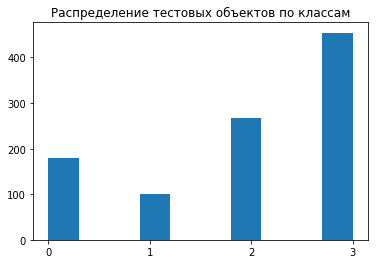

In [91]:
plt.title('Распределение тестовых объектов по классам')
plt.hist(submission['accuracy_group'])
plt.xticks([0, 1, 2, 3])
plt.show()

## Adversarial Validation


In [92]:
# if ADVERSARIAL_VALIDATION and not IS_SUBMITTING:
#     from sklearn.metrics import roc_auc_score
#     from sklearn.model_selection import train_test_split

#     av_clf = CatBoostClassifier(random_state = RANDOM_SEED,
#                                 loss_function = 'Logloss',
#                                 cat_features=categorical_features,
#                                 custom_metric='AUC',
#                                 eval_metric='AUC',
#                                 verbose=100,
#                                 metric_period=100,
#                                 num_trees=400)

#     X_train = train.drop(columns=exclude_features)
#     y_train = np.zeros(X_train.shape[0])
#     X_test  = test.drop(columns=exclude_features)
#     y_test  = np.ones(X_test.shape[0])

#     X = pd.concat([X_train, X_test], axis=0)
#     y = np.concatenate([y_train, y_test])

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=RANDOM_SEED)

#     av_clf.fit(X_train, y_train)           

#     av_roc_auc = roc_auc_score(y_test, av_clf.predict_proba(X_test)[:,1])

#     if av_roc_auc < 0.6:
#         print(f'AV ROC AUC {av_roc_auc:.3f}')
#     else:
#         print(f'AV ROC AUC {av_roc_auc:.3f} :::: WARNING!!! ')
#         print('The most suspicious features are:')
#         features = pd.DataFrame({'feature': X.columns, 'importance': av_clf.feature_importances_})
#         features.sort_values(by=['importance'], ascending=False, inplace=True)
#         for i in range(10):
#             print(f'  {features.feature.iloc[i]}: {features.importance.iloc[i]:.4f}')